# Unveiling Bias in Gender Violence Perception on Italian Social Media

## Importing Libraries

In [1]:
%pip install clean-text

In [2]:
# import all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import regex as re
import spacy
from cleantext import clean
from sklearn.metrics.pairwise import cosine_similarity

Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.


In [3]:
!python -m spacy download it_core_news_sm

     ---------------------------------------- 0.0/13.0 MB ? eta -:--:--
     - -------------------------------------- 0.5/13.0 MB 11.1 MB/s eta 0:00:02
     ---- ----------------------------------- 1.3/13.0 MB 14.0 MB/s eta 0:00:01
     ------ --------------------------------- 2.2/13.0 MB 15.8 MB/s eta 0:00:01
     ---------- ----------------------------- 3.5/13.0 MB 18.6 MB/s eta 0:00:01
     ------------- -------------------------- 4.6/13.0 MB 19.4 MB/s eta 0:00:01
     ----------------- ---------------------- 5.6/13.0 MB 19.8 MB/s eta 0:00:01
     ---------------------- ----------------- 7.3/13.0 MB 22.3 MB/s eta 0:00:01
     ---------------------------- ----------- 9.3/13.0 MB 24.9 MB/s eta 0:00:01
     --------------------------------- ----- 11.1/13.0 MB 28.4 MB/s eta 0:00:01
     ------------------------------------- - 12.7/13.0 MB 31.2 MB/s eta 0:00:01
     --------------------------------------  13.0/13.0 MB 31.2 MB/s eta 0:00:01
     --------------------------------------- 13.

## Reading and Cleaning Data

### Read Df

This data frame comes from extensive and hard scraping on Nitter, one of the last available resources to scrape Twitter without rate limits and high expenses. However, because of the instability of the various instances, we are not sure the results will be easily replicated if trying to run again the twitter.ipynb script. 

In [4]:
# read the data
df = pd.read_csv('twitter_data.csv')

In [5]:
# drop the first column
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,user,username,date,text,comments,retweets,quotes,likes
0,Sciking,@ScikingFS,Apr 19,"Se solo le donne possono parlare di aborto, so...",0,0,0,0
1,💲ℹ️〽️⭕.🇪🇺🇺🇦 #Il Silenzio é Sottovalutato❣️©🤫,@Simo42953017,Apr 19,#femminicidio #femminicidi,0,0,0,0
2,pubblicanow.it,@pubblicanow,Apr 19,Paesi Baschi: aiuto annuale per gli orfani di ...,0,0,0,0
3,Italy in Austria,@ItalyinAustria,Apr 19,L'Ambasciata d'Italia a Vienna aderisce alla c...,0,0,0,0
4,𝙈𝙖𝙧𝙠 𝙋. 𝙇𝙚 𝙃𝙖𝙫𝙧𝙚,@marklehavre,Apr 19,Bhe speriamo che non sia per qualche femminici...,0,0,0,1


In [6]:
# check the data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40921 entries, 0 to 40920
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user      40921 non-null  object
 1   username  40921 non-null  object
 2   date      40921 non-null  object
 3   text      40921 non-null  object
 4   comments  40921 non-null  int64 
 5   retweets  40921 non-null  object
 6   quotes    40921 non-null  int64 
 7   likes     40921 non-null  object
dtypes: int64(2), object(6)
memory usage: 2.5+ MB


In [7]:
# check date data type
df['date'].unique()

array(['Apr 19', 'Apr 18', 'Apr 15', 'Mar 8', 'Apr 17', '6 Dec 2023',
       '18 Nov 2023', 'Apr 16', 'Apr 13', 'Apr 14', 'Apr 12', 'Apr 11',
       'Apr 10', 'Apr 9', 'Apr 8', 'Apr 7', 'Apr 6', 'Apr 5', 'Apr 4',
       'Apr 3', 'Apr 2', 'Apr 1', 'Mar 31', 'Mar 30', 'Mar 29', 'Mar 28',
       'Mar 27', 'Mar 26', 'Mar 25', 'Mar 24', 'Mar 23', 'Mar 22',
       'Mar 21', 'Mar 20', 'Mar 19', 'Mar 18', 'Mar 17', 'Mar 16',
       'Mar 15', 'Mar 14', 'Mar 13', 'Mar 12', 'Mar 11', 'Mar 10',
       'Mar 9', 'Mar 7', 'Mar 6', 'Mar 5', 'Mar 4', 'Mar 3', 'Mar 2',
       'Mar 1', 'Feb 29', 'Feb 28', 'Feb 27', 'Feb 26', 'Feb 25',
       'Feb 24', 'Feb 23', 'Feb 22', 'Feb 21', 'Feb 20', 'Feb 19',
       'Feb 18', 'Feb 17', 'Feb 16', 'Feb 15', 'Feb 14', 'Feb 13',
       'Feb 12', 'Feb 11', 'Feb 10', 'Feb 9', 'Feb 8', 'Feb 7', 'Feb 6',
       'Feb 5', 'Feb 4', 'Feb 3', 'Feb 2', 'Feb 1', 'Jan 31', 'Jan 30',
       'Jan 29', 'Jan 28', 'Jan 27', 'Jan 26', 'Jan 25', 'Jan 24',
       'Jan 23', 'Jan 22', 'Ja

The dates of 2024 have been saved with just day and month, therefore we need to add the year

In [8]:
len('9 Dec 2023')

10

In [9]:
# add the year to all the dates of 2024
df['date'] = df['date'].apply(lambda x: x + ' 2024' if len(x) < 10 else x)

In [10]:
# convert the date to datetime
df['date'] = pd.to_datetime(df['date'])

In [11]:
# clean the text column
df['text'] = df['text'].apply(lambda x: x.replace('\n', ' '))

In [12]:
# first five rows
df.head()

,user,username,date,text,comments,retweets,quotes,likes
0,Sciking,@ScikingFS,2024-04-19,"Se solo le donne possono parlare di aborto, so...",0,0,0,0
1,💲ℹ️〽️⭕.🇪🇺🇺🇦 #Il Silenzio é Sottovalutato❣️©🤫,@Simo42953017,2024-04-19,#femminicidio #femminicidi,0,0,0,0
2,pubblicanow.it,@pubblicanow,2024-04-19,Paesi Baschi: aiuto annuale per gli orfani di ...,0,0,0,0
3,Italy in Austria,@ItalyinAustria,2024-04-19,L'Ambasciata d'Italia a Vienna aderisce alla c...,0,0,0,0
4,𝙈𝙖𝙧𝙠 𝙋. 𝙇𝙚 𝙃𝙖𝙫𝙧𝙚,@marklehavre,2024-04-19,Bhe speriamo che non sia per qualche femminici...,0,0,0,1


This is the cleaned final data frame!

## Exploratory Data Analysis

### Polarization event

We chose as a polarization event the "Cecchettin case", that greatly moved public opinion regarding the hot topic of violence on women in italy.

In [13]:
# create a variable for the polarizing event
pol_event = dt.datetime(2023, 11, 11)

### Simple Tweet Count

In [14]:
# group the data by date
count_by_date = df.groupby('date').count()
count_by_date.head()

,user,username,text,comments,retweets,quotes,likes
date,,,,,,,
2023-06-15,3,3,3,3,3,3,3
2023-06-16,23,23,23,23,23,23,23
2023-06-17,12,12,12,12,12,12,12
2023-06-18,27,27,27,27,27,27,27
2023-06-19,22,22,22,22,22,22,22


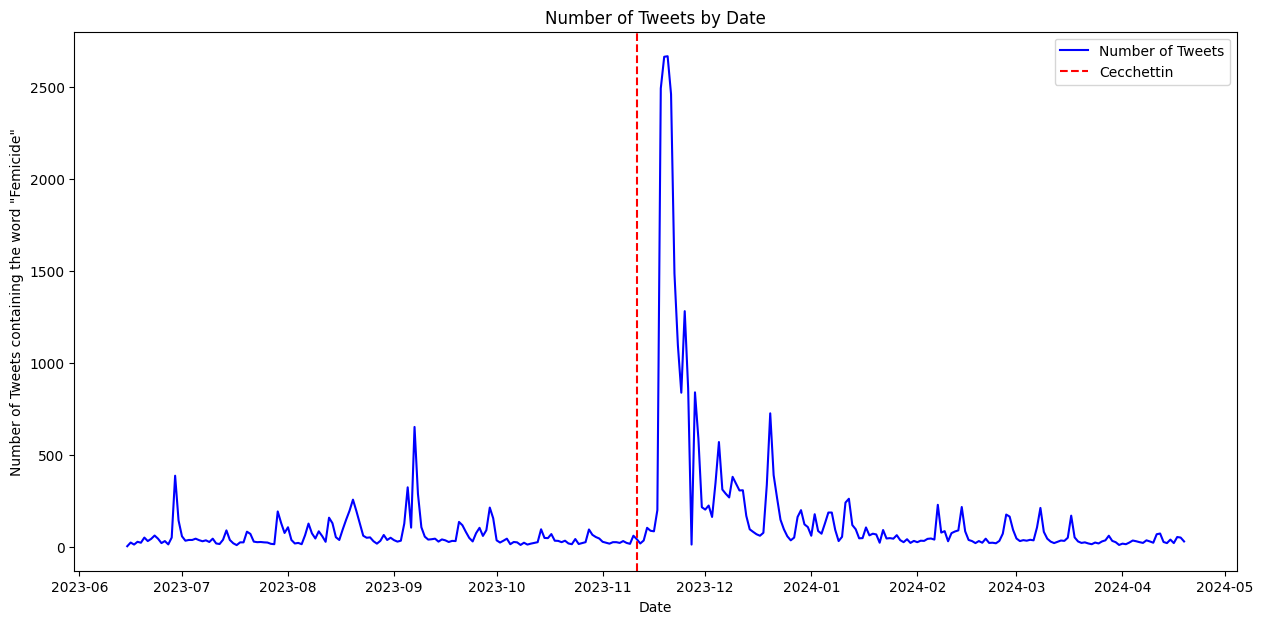

In [15]:
# plot the number of tweets by date
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(count_by_date.index, count_by_date['text'], label='Number of Tweets', color='blue')
ax.axvline(pol_event, color='red', linestyle='--', label='Cecchettin')
ax.set_title('Number of Tweets by Date')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Tweets containing the word "Femicide"')
ax.legend()

plt.show()

### Number of Different Users

In [16]:
# count the number of different users
n_different_users = df['user'].nunique()
print(f'There are {n_different_users} different users in the dataset (that contains {len(df)} tweets)')

There are 17773 different users in the dataset (that contains 40921 tweets)


There are 17773 different users in the dataset (that contains 40921 tweets)

In [17]:
# list of all different users
different_users = df['user'].unique()
different_users

array(['Sciking', '💲ℹ️〽️⭕.🇪🇺🇺🇦 #Il Silenzio é Sottovalutato❣️©🤫',
       'pubblicanow.it', ..., 'Marco Donadel', 'gabriele farina',
       'The Baseball Furies'], dtype=object)

In [18]:
users_df = df.groupby('user').agg(list).reset_index()
users_df['username'] = users_df['username'].apply(lambda x: x[0])
users_df.head()

,user,username,date,text,comments,retweets,quotes,likes
0,raffaele52,@raffaele521,[2023-11-21 00:00:00],[La sua conoscenza del femminicidio è straordi...,[0],[0],[0],[0]
1,Shana Loricco,@shanaloricco201,[2023-12-05 00:00:00],"[Parole forti, chiare. Giuste. #LorenzoGasparr...",[0],[0],[0],[0]
2,"""Lehodettocresci"" E io sono cresciuta🌈🌻",@nagioia08,[2023-10-04 00:00:00],[D'altronde Pi3rsilvio ha cacciato la d'urso p...,[0],[0],[0],[ 8]
3,# claudia ✧ 🔭,@308bangtan,[2023-08-01 00:00:00],"[in realtà penalmente parlando non è uguale, u...",[0],[0],[0],[0]
4,#@&,@SalzanoBruna,"[2023-11-22 00:00:00, 2023-11-22 00:00:00, 202...",[Non per commentare me. Se credi tanto al risp...,"[0, 1, 2]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]"


In [19]:
users_df['n_tweets'] = users_df['text'].apply(lambda x: len(x))

### Number of Tweets per User

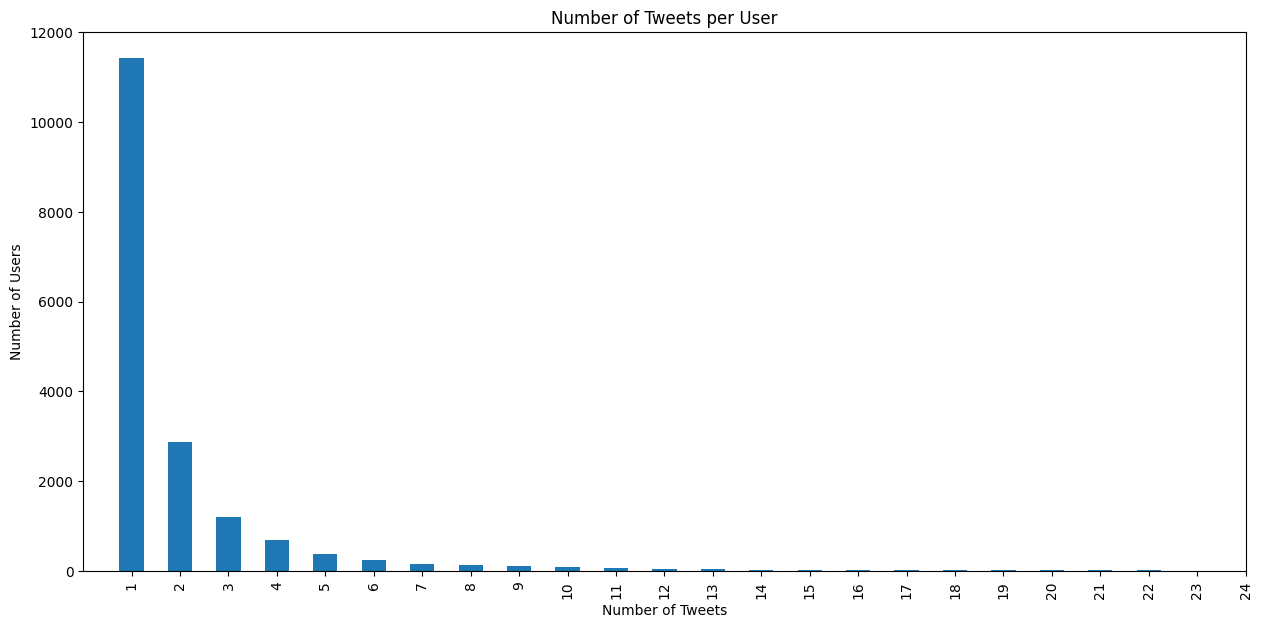

In [20]:
fig, ax = plt.subplots(figsize=(15, 7))
users_df['n_tweets'].value_counts().sort_index().plot(kind='bar', ax=ax)
ax.set_title('Number of Tweets per User')
ax.set_xlabel('Number of Tweets')
ax.set_ylabel('Number of Users')
ax.set_xlim(-1, 23)

plt.show()

## Data Processing

### Split Dates

In [22]:
pol_event_date = dt.datetime(2023, 11, 11)
df['after'] = 0
df.loc[df['date'] > pol_event_date, 'after'] = 1

### Create Hashtag Column

In [23]:
# function to get hashtags
def get_hashtags(text):
    hashtags = re.findall(r'#\w+', text)
    if hashtags != []:
        return re.findall(r'#\w+', text)
    else:
        return np.nan

In [24]:
df['hashtags'] = df['text'].apply(get_hashtags)

In [25]:
df.loc[df['hashtags'].notna(), 'hashtags'].reset_index(drop=True)

0                            [#femminicidio, #femminicidi]
1                                               [#Raiplay]
2                                          [#Femminicidio]
3                    [#Attualità, #Italia, #UltimeNotizie]
4                                   [#Sardegna, #violenza]
                               ...                        
13729                            [#isola, #isoladeifamosi]
13730    [#parole, #discriminazione, #pregiudizi, #ster...
13731    [#Femminicidio, #ConsigliodeiMinistri, #violen...
13732    [#WoltersKluwerItalia, #Femminicidio, #Violenz...
13733                                        [#IoSeguoTgr]
Name: hashtags, Length: 13734, dtype: object

### Clean Tweets

In [26]:
def remover(text, chars = ['@', '#', 'http'], emojis = True):
    if emojis == True:
        starting_chars = '|'.join(chars)
        for word in text.split():
            if re.match(f'{starting_chars}[A-za-z]+', word):
                text = text.replace(word, '')
                
    return text

In [27]:
text = "This sample text contains laughing emojis 😀 😃 😄 😁 😆 😅 😂 🤣"

#print text after removing the emojis from it
clean(remover(text), no_emoji = True)

'this sample text contains laughing emojis'

In [28]:
df['clean_text'] = df['text'].apply(lambda x: remover(x).lower())
df['clean_text'] = df['clean_text'].apply(lambda x: clean(x, no_urls=True, no_emails=True, no_phone_numbers=True, no_numbers=True, no_digits=True, no_currency_symbols=True, no_punct=True, no_emoji=True, replace_with_url='', replace_with_email='', replace_with_phone_number='', replace_with_number='', replace_with_digit='', replace_with_currency_symbol='', replace_with_punct=''))

In [29]:
nlp = spacy.load('it_core_news_sm')

In [30]:
texts_before = df.loc[df['after'] == 0, 'clean_text'].values
texts_after = df.loc[df['after'] == 1, 'clean_text'].values
documents_before = list(nlp.pipe(texts_before))
documents_after = list(nlp.pipe(texts_after))


In [31]:
corpus_before = [[word.text for word in doc if not word.is_stop] for doc in documents_before]
corpus_after = [[word.text for word in doc if not word.is_stop] for doc in documents_after]

In [43]:
corpus_before

[['mammuccari',
  'pesante',
  'peperonata',
  'destate',
  'dirti',
  'molesto',
  'poca',
  'rispetto',
  'penso',
  'viviamo',
  'femminicidio',
  'comporti',
  'lucarelli',
  'palese',
  'menti',
  'approvazione',
  'pubblico'],
 ['vero',
  'dici',
  'idea',
  'significhi',
  'femminicidio',
  'dicendo',
  'i',
  'giudici',
  'stabilito',
  'interrompere',
  'effetti',
  'accanimento',
  'terapeutico',
  'femmina',
  'maschio',
  'continuare',
  'cure',
  'seriamente'],
 ['femminicidio',
  'legalizzatoma',
  'metti',
  'calicepretesei',
  'vergognosoma',
  'vescovo',
  'sa',
  'cazzate',
  'scrivi'],
 ['mischione', 'femminicidio'],
 ['usare', 'i', 'termini', 'tasso', 'femminicidio'],
 ['neanche', 'sai', 'femminicidio', 'rincoglionito'],
 ['cazzo',
  'centra',
  'femminicidioma',
  'daltra',
  'chiesa',
  'santifica',
  'venera',
  'madre',
  'teresa',
  'aspettavi',
  'patisci'],
 ['dimenticato', 'definizione', 'femminicidio', 'ripassino'],
 ['femminicidio'],
 ['parole',
  'femmini

In [32]:
from gensim.models import word2vec
import os

w2v_before = word2vec.Word2Vec(corpus_before, vector_size=100, window=5, min_count=1, workers=os.cpu_count())
w2v_after = word2vec.Word2Vec(corpus_after, vector_size=100, window=5, min_count=1, workers=os.cpu_count())

In [52]:
w2v_before.wv.most_similar('giustizia')

[('leggi', 0.9998610019683838),
 ('parla', 0.9998460412025452),
 ('morte', 0.9998382925987244),
 ('legge', 0.9998340606689453),
 ('femminicidio', 0.9998334050178528),
 ('famiglia', 0.9998305439949036),
 ('de', 0.9998250007629395),
 ('cose', 0.9998183250427246),
 ('parlare', 0.9998170137405396),
 ('societa', 0.9998162984848022)]

In [53]:
w2v_after.wv.most_similar('giustizia')

[('foto', 0.9993066191673279),
 ('viva', 0.9988321661949158),
 ('strumentalizzare', 0.9987639784812927),
 ('diretta', 0.9987387657165527),
 ('avra', 0.9987239837646484),
 ('riesco', 0.998608410358429),
 ('voglio', 0.9986083507537842),
 ('temo', 0.9984441995620728),
 ('corteo', 0.9983769655227661),
 ('lacrime', 0.9983100891113281)]

In [67]:
def similaity_before_after(words, model_before, model_after):
    if type(words) == str:
        try:
            vec_before = model_before.wv[words]
            vec_after = model_after.wv[words]
            similarity = cosine_similarity([vec_before], [vec_after])
            return {words: similarity[0][0]}
        except KeyError:
            return {words: 'word not in vocabulary'}
    else:
        similarities = {}
        for word in words:
            try:
                vec_before = model_before.wv[word]
                vec_after = model_after.wv[word]
                similarity = cosine_similarity([vec_before], [vec_after])
                similarities[word] = similarity[0][0]
            except KeyError:
                similarities[word] = 'word not in vocabulary'
        return similarities

In [66]:
word = 'femminicidio'
similarity = similaity_before_after(word, w2v_before, w2v_after)
print(f'the similarity between the word {word} before and after the event is {similarity[word]}')

the similarity between the word femminicidio before and after the event is 0.6622196435928345


In [58]:


# Get the vector for "femminicidio" from both models
vec_before = w2v_before.wv["femminicidio"]
vec_after = w2v_after.wv["femminicidio"]

# Calculate cosine similarity
similarity = cosine_similarity(vec_before.reshape(1, -1), vec_after.reshape(1, -1))

print(f"Cosine similarity between 'femminicidio' before and after: {similarity[0][0]}")


Cosine similarity between 'femminicidio' before and after: 0.6622196435928345
